In [1]:
!git clone https://github.com/chenmingxiang110/Growing-Neural-Cellular-Automata.git



Cloning into 'Growing-Neural-Cellular-Automata'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 57 (delta 10), reused 4 (delta 4), pack-reused 38
Receiving objects: 100% (57/57), 3.60 MiB | 1.11 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/home/pesquisavcl/pesquisa/filipe/automatos/Growing-Neural-Cellular-Automata


In [1]:
%cd Growing-Neural-Cellular-Automata

/home/pesquisavcl/pesquisa/filipe/automatos/Growing-Neural-Cellular-Automata


In [2]:

%matplotlib inline
import time
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output

from lib.CAModel import CAModel, LCAModel, CCAModel
from lib.utils_vis import SamplePool, to_alpha, to_rgb, get_living_mask, make_seed, make_circle_masks
import torch

print(torch.version.cuda)

12.1


In [3]:
def load_emoji(index, path="C:/Users/andre/OneDrive/Imagens/gato_png.png", target_size=40):
    #im = imageio.imread(path)
    im = imageio.imread(path, pilmode='RGBA')  #FILIPE
    
    #emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji = np.array(im.astype(np.float32))
    #emoji = cv2.resize(emoji, (40, 40))
    emoji = cv2.resize(emoji, (target_size, target_size))
    emoji /= 255.0
    return emoji

def load_recorte_emoji(index, path="C:/Users/andre/OneDrive/Imagens/gato_png.png", target_size=40):
    #im = imageio.imread(path)
    im = imageio.imread(path, pilmode='RGBA')  #FILIPE
    
    #emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji = np.array(im.astype(np.float32))
    #emoji = cv2.resize(emoji, (40, 40))
    #emoji = cv2.resize(emoji, (target_size, target_size))
    #emoji = emoji[:target_size][:target_size]
    #emoji = emoji[40:40+target_size,:target_size]
    emoji = emoji[20:20+target_size,5:5+target_size]
    emoji /= 255.0
    return emoji

def visualize_batch(x0, x):
    vis0 = to_rgb(x0)
    vis1 = to_rgb(x)
    print('batch (before/after):')
    plt.figure(figsize=[15,5])
    for i in range(x0.shape[0]):
        plt.subplot(2,x0.shape[0],i+1)
        plt.imshow(vis0[i])
        plt.axis('off')
    for i in range(x0.shape[0]):
        plt.subplot(2,x0.shape[0],i+1+x0.shape[0])
        plt.imshow(vis1[i])
        plt.axis('off')
    plt.show()

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

In [4]:
device = torch.device("cuda:0")
model_path = "models/remaster_45.pth"

CHANNEL_N = 8   # Number of CA state channels
#CHANNEL_N = 60        # Number of CA state channels
TARGET_PADDING = 1   # Number of pixels used to pad the target image border
#TARGET_PADDING = 8   # Number of pixels used to pad the target image border
TARGET_SIZE = 3

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
#n_epoch = 80000
#n_epoch = 5000
n_epoch = 50000

BATCH_SIZE = 8
POOL_SIZE = 1024
#CELL_FIRE_RATE = 0.5 #testar com 1.0
CELL_FIRE_RATE = 0.2 #testar com 1.0

TARGET_EMOJI = 5 #@param "🦎"

EXPERIMENT_TYPE = "Persistent"
# EXPERIMENT_TYPE = "Regenerating" #testar os tres pra ver o resultado melhor
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

(3, 3, 4)


/tmp/ipykernel_1770864/1230077178.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path, pilmode='RGBA')  #FILIPE


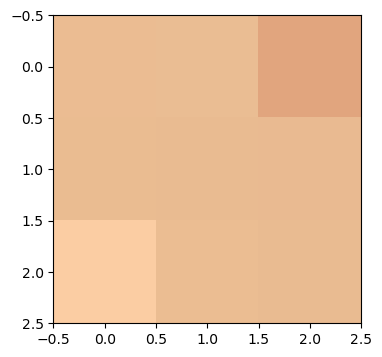

In [5]:
#target_img = load_emoji(TARGET_EMOJI, path="C:/Users/andre/OneDrive/Imagens/gato_png.png")
#nome_imagem = "caracol_png.png"
nome_imagem = "caracol40.png"
#nome_imagem = "mesa.jpg"
#target_img = load_emoji(TARGET_EMOJI, path="data/caracol_png.png", target_size=TARGET_SIZE)
#target_img = load_emoji(TARGET_EMOJI, path=f"data/{nome_imagem}", target_size=TARGET_SIZE)
target_img = load_recorte_emoji(TARGET_EMOJI, path=f"data/{nome_imagem}", target_size=TARGET_SIZE)
plt.figure(figsize=(4,4))
print(target_img.shape)
if target_img.shape[2] >3:
    plt.imshow(to_rgb(target_img))
else:
    plt.imshow(target_img)
plt.show()


In [6]:
_25425p = TARGET_PADDING
pad_target = np.pad(target_img, [(_25425p, _25425p), (_25425p, _25425p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32)).to(device)


seed = make_seed((h, w), CHANNEL_N)
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(BATCH_SIZE).x

#ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device).to(device)
ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=3).to(device)
#ca = CCAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=128, num_filters = 128, kernel_size=3).to(device)
#ca = LCAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=128).to(device)
#ca.load_state_dict(torch.load(model_path))




optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)


#filipe
# create a quantized model instance
ca2 = torch.ao.quantization.quantize_dynamic(
    ca,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)

# print(ca2.parameters())

In [7]:
model = ca
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

print(param_size, buffer_size,param_size + buffer_size)
size_all_mb = (param_size + buffer_size) / 1024**2
size_all_kb = (param_size + buffer_size) / 1024**1
print('model size: {:.3f}MB'.format(size_all_mb))
print('model size: {:.3f}KB'.format(size_all_kb))
# > model size: 44.629MB

396 0 396
model size: 0.000MB
model size: 0.387KB


In [8]:
from torchsummary import summary


summary(ca, (3, 3, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 3, 3, 3]              75
            Linear-2              [-1, 3, 3, 8]              24
Total params: 99
Trainable params: 99
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [9]:
import os

def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

# compare the sizes
f=print_size_of_model(ca,"fp32")
q=print_size_of_model(ca2,"int8")
print("{0:.2f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 2.111
model:  int8  	 Size (KB): 3.235
0.65 times smaller


In [10]:
pad_target.shape

torch.Size([1, 5, 5, 4])

50000 loss = 0.01131109707057476
batch (before/after):


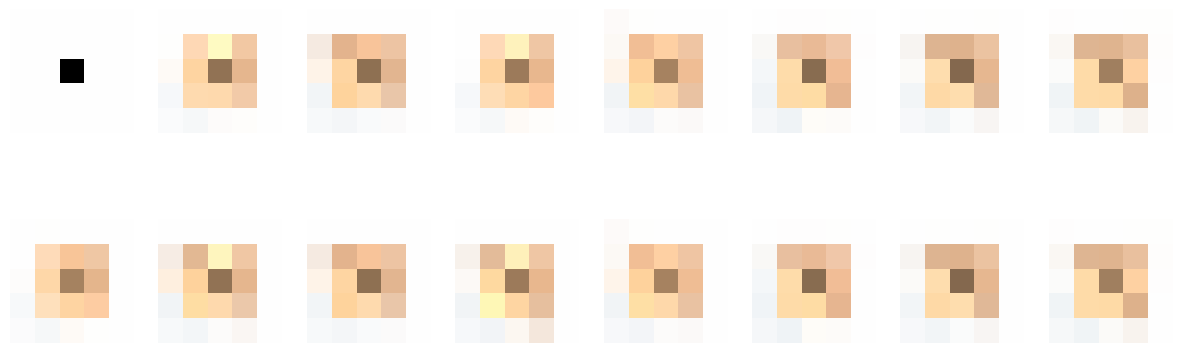

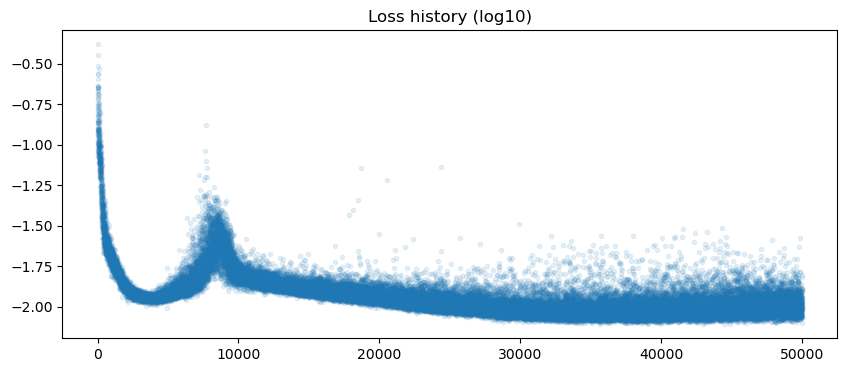

In [11]:
loss_log = []

def train(x, target, steps, optimizer, scheduler):
    x = ca(x, steps=steps)
    #import pdb;pdb.set_trace()
    if target.shape[-1]>3:
        loss = F.mse_loss(x[:, :, :, :4], target)
    else:
        loss = F.mse_loss(x[:, :, :, :3], target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return x, loss

def loss_f(x, target):
    if target.shape[-1]>3:
        return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])
    else:
        return torch.mean(torch.pow(x[..., :3]-target, 2), [-2,-3,-1])

for i in range(n_epoch+1):

    if USE_PATTERN_POOL:
        batch = pool.sample(BATCH_SIZE)
        x0 = torch.from_numpy(batch.x.astype(np.float32)).to(device)
        loss_rank = loss_f(x0, pad_target).detach().cpu().numpy().argsort()[::-1]
        x0 = batch.x[loss_rank]
        x0[:1] = seed
        if DAMAGE_N:
            damage = 1.0-make_circle_masks(DAMAGE_N, h, w)[..., None]
            x0[-DAMAGE_N:] *= damage
    else:
        x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    #x, loss = train(x0, pad_target, np.random.randint(64,96), optimizer, scheduler)
    x, loss = train(x0, pad_target, np.random.randint(16,24), optimizer, scheduler)
    
    

    if USE_PATTERN_POOL:
        batch.x[:] = x.detach().cpu().numpy()
        batch.commit()

    step_i = len(loss_log)
    loss_log.append(loss.item())

    if step_i%100 == 0:
        clear_output()
        print(step_i, "loss =", loss.item())
        visualize_batch(x0.detach().cpu().numpy(), x.detach().cpu().numpy())
        plot_loss(loss_log)
        torch.save(ca.state_dict(), model_path)

## Generate image with inference

In [12]:
import tqdm

#loaded_ca = ca.load_state_dict(torch.load(model_path)).to(device)

loaded_ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=3).to(device)
#ca = LCAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=8).to(device)
#loaded_ca = CCAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=128, num_filters = 128, kernel_size=3).to(device)
loaded_ca.load_state_dict(torch.load(model_path))

x = np.zeros([1, 64, 64, CHANNEL_N], np.float32)

#x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
x0 = np.repeat(seed[None, ...], 1, 0)
x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

xf = loaded_ca(x0,steps=96)

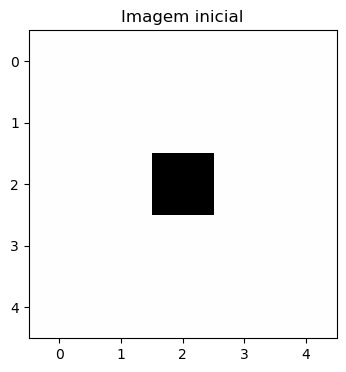

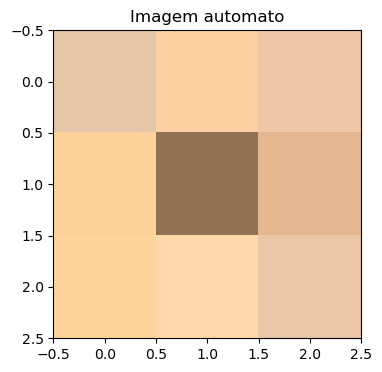

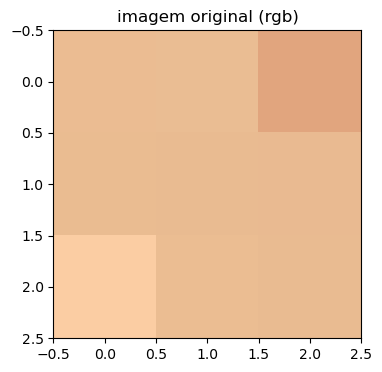

In [13]:
#Filipe's code
input_rgb = to_rgb(x0.detach().cpu().numpy())
output_rgb = to_rgb(xf.detach().cpu().numpy())
target_rgb = to_rgb(target_img)

#unpading
output_image = output_rgb[0]
#unpad_output_image = output_image[TARGET_PADDING:output_image.shape[0]-TARGET_PADDING][TARGET_PADDING:output_image.shape[1]-TARGET_PADDING]
unpad_output_image = output_image[TARGET_PADDING:output_image.shape[0]-TARGET_PADDING, TARGET_PADDING:output_image.shape[1]-TARGET_PADDING]


plt.figure(figsize=(4,4))
plt.imshow(input_rgb[0])
plt.title("Imagem inicial")

plt.figure(figsize=(4,4))
plt.imshow(unpad_output_image)
plt.title("Imagem automato")

plt.figure(figsize=(4,4))
plt.imshow(to_rgb(target_img))
plt.title("imagem original (rgb)")
plt.show()

In [13]:
#Filipe's code
input_rgb = to_rgb(x0.detach().cpu().numpy())
output_rgb = to_rgb(x.detach().cpu().numpy())
target_rgb = to_rgb(target_img)


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [14]:
from PIL import Image

path_img_automato = "data/automato_cca.png"
path_original = "data/target_cca.png"

unpad_output_image_ = unpad_output_image * 255
unpad_output_image_ = unpad_output_image_.astype(np.uint8)
im = Image.fromarray(unpad_output_image_)
#im.save("data/automato_cca.png", "PNG")
im.save(path_img_automato, "PNG")


temp = to_rgb(target_img)* 255
temp_ = temp.astype(np.uint8)
im2 = Image.fromarray(temp_)
# im2 = Image.fromarray(target_img)
#im2.save("data/target_cca.png", "PNG")
im2.save(path_original, "PNG")

In [15]:
import os
# print(os.stat("data/automato.png").st_size)
# print(os.stat("data/target.png").st_size)
# print(os.stat("data/caracol_png.png").st_size)

print(os.stat(path_img_automato).st_size)
print(os.stat(path_original).st_size)
print(os.stat("data/caracol_png.png").st_size)

1580
932
26369


In [ ]:
# from PIL import Image


# unpad_output_image_ = unpad_output_image * 255
# unpad_output_image_ = unpad_output_image_.astype(np.uint8)
# im = Image.fromarray(unpad_output_image_)
# im.save("img_automato_rgb_peru_R.png", "PNG")


# target_image_ = to_rgb(target_img) * 255
# target_image_ = target_image_.astype(np.uint8)
# im = Image.fromarray(target_image_)
# im.save("img_target_rgb_peru_R.png", "PNG")

# import shutil


# caminho_img_automato = "img_automato_rgb_peru_R.png"
# caminho_img_original = "img_target_rgb_peru_R.png"


# diretorio_destino = "C:/Users/andre/OneDrive/Imagens/imagem automatos"


# shutil.move(caminho_img_automato, diretorio_destino)
# shutil.move(caminho_img_original, diretorio_destino)


In [16]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
import os



#imagem_automato = imread("C:/Users/andre/OneDrive/Imagens/imagem automatos/img_automato_rgb_peru_R.png")
imagem_automato = imread(path_img_automato)
#imagem_original = imread("C:/Users/andre/OneDrive/Imagens/imagem automatos/img_target_rgb_peru_R.png")
imagem_original = imread(path_original)



mse = mean_squared_error(imagem_original, imagem_automato)
psnr = peak_signal_noise_ratio(imagem_original, imagem_automato)
ssim = structural_similarity(imagem_original, imagem_automato, win_size=3, multichannel=True)


print("PSNR (Peak Signal-to-Noise Ratio):", psnr)
print("MSE (Mean Squared Error):", mse)
print("SSIM (Structural Similarity Index):", ssim)

import os


# caminho_img_original = "C:/Users/andre/OneDrive/Imagens/imagem automatos/img_target_rgb_peru_R.png"
# caminho_img_automato = "C:/Users/andre/OneDrive/Imagens/imagem automatos/img_automato_rgb_peru_R.png"


def tamanho_arquivo(caminho):
    # return os.path.getsize(caminho)
    #print(os.stat(caminho).st_size)
    return os.stat(caminho).st_size



#tamanho_original = tamanho_arquivo(caminho_img_original)
tamanho_original = tamanho_arquivo(path_original)
#tamanho_automato = tamanho_arquivo(caminho_img_automato)
tamanho_automato = tamanho_arquivo(path_img_automato)


print("Tamanho da imagem original:", tamanho_original, "bytes")
print("Tamanho da imagem gerada pelo autômato:", tamanho_automato, "bytes")

def calcular_bits_por_pixel(caminho_imagem, tamanho_arquivo):
    imagem = imread(caminho_imagem)
    largura, altura, _ = imagem.shape
    total_pixels = largura * altura
    bits_por_pixel = (tamanho_arquivo * 8) / total_pixels
    return bits_por_pixel

#bits_por_pixel_original = calcular_bits_por_pixel(caminho_img_original, tamanho_original)
bits_por_pixel_original = calcular_bits_por_pixel(path_original, tamanho_original)
#bits_por_pixel_automato = calcular_bits_por_pixel(caminho_img_automato, tamanho_automato)
bits_por_pixel_automato = calcular_bits_por_pixel(path_img_automato, tamanho_automato)

print("Bits por Pixel da imagem original:", bits_por_pixel_original)
print("Bits por Pixel da imagem gerada pelo autômato:", bits_por_pixel_automato)


PSNR (Peak Signal-to-Noise Ratio): 50.94129109650922
MSE (Mean Squared Error): 0.5235416666666667
SSIM (Structural Similarity Index): 0.9998726569103771
Tamanho da imagem original: 932 bytes
Tamanho da imagem gerada pelo autômato: 1580 bytes
Bits por Pixel da imagem original: 4.66
Bits por Pixel da imagem gerada pelo autômato: 7.9
